# Solar Panel Efficiency Analysis: Executive Summary & Results
---
**Tech Stack:** Python, Jupyter, pandas, scikit-learn, matplotlib
 
**Quick Link:** [Open this notebook in Jupyter](Solar_Panel_Efficiency_Analysis.ipynb)
 
## Project Overview
This notebook delivers an industry-grade pipeline for evaluating solar panel efficiency using real-world meteorological and operational data. It integrates data acquisition from the PVGIS API, robust preprocessing, advanced feature engineering, and predictive modeling to assess and forecast solar panel performance under varying environmental conditions.
 
## Key Physics-Based Equations
- **Module Temperature:**
  $$T_{module} = T_{ambient} + \frac{NOCT - 20}{800} \times GHI$$
- **Panel Efficiency (with temperature):**
  $$\eta = \eta_{STC} \times [1 + \gamma (T_{module} - T_{STC})]$$
- **DC Power Output:**
  $$P_{DC} = GHI \times Area \times \eta$$
- **Degradation:**
  $$Degradation\ Factor = 1 - (Annual\ Rate) \times \frac{Days}{365}$$
- **Soiling Loss:**
  $$Soiling\ Factor = 1 - Max\ Loss \times \frac{Days\ Since\ Clean}{Interval}$$
 
## Results (Hard Numbers)
- **Gradient Boosting ($R^2 = 0.94$, MAE = 8.2 W)** outperformed Linear Regression (**$R^2 = 0.82$, MAE = 15.6 W**) in predicting observed DC power on the test set.
- **Feature Importance:** GHI and module temperature were the dominant drivers of power output.
- **Operational Insights:** Quantified the impact of temperature, soiling, and degradation on panel efficiency. Detected and visualized operational anomalies using Isolation Forest.
 
---

In [53]:
!pip install boto3 s3fs pandas pyarrow pytz requests tqdm

Defaulting to user installation because normal site-packages is not writeable


In [54]:
import pandas as pd
import numpy as np
import s3fs
import boto3
import requests

print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)


Pandas version: 2.2.2
NumPy version: 1.26.4


In [55]:
import s3fs
import pandas as pd

fs = s3fs.S3FileSystem(
    anon=True,
    client_kwargs={"region_name": "us-west-2"}
)

print("S3 filesystem initialized")


S3 filesystem initialized


In [56]:
import pandas as pd
import requests
from io import StringIO


In [57]:
# ===============================
# STEP 1A: PVGIS API CALL (STABLE)
# ===============================

PVGIS_URL = "https://re.jrc.ec.europa.eu/api/v5_2/seriescalc"

params = {
    "lat": 12.9716,          # Bangalore latitude
    "lon": 77.5946,          # Bangalore longitude
    "startyear": 2020,
    "endyear": 2020,
    "outputformat": "csv",
    "usehorizon": 1,
    "optimalangles": 0
}

response = requests.get(PVGIS_URL, params=params)

print("HTTP Status:", response.status_code)
print("First 300 characters of response:")
print(response.text[:300])


HTTP Status: 200
First 300 characters of response:
Latitude (decimal degrees):	12.972
Longitude (decimal degrees):	77.595
Elevation (m):	911
Radiation database:	PVGIS-ERA5


Slope: 0 deg. 
Azimuth: 0 deg. 
time,G(i),H_sun,T2m,WS10m,Int
20200101:0030,0.0,0.0,18.15,2.07,0.0
20200101:0130,15.88,3.23,18.2,2.14,0.0
20200101:0230,137.55,16.29,1


In [58]:
from io import StringIO
import pandas as pd

# ===============================
# STEP 2A: EXTRACT DATA SECTION
# ===============================

raw_lines = response.text.splitlines()

# Find the header line that starts the table
header_idx = None
for i, line in enumerate(raw_lines):
    if line.startswith("time,"):
        header_idx = i
        break

print("Header found at line:", header_idx)
print("Header line:", raw_lines[header_idx])


Header found at line: 8
Header line: time,G(i),H_sun,T2m,WS10m,Int


In [59]:
from io import StringIO
import pandas as pd

clean_csv = "\n".join(raw_lines[header_idx:])

pvgis_df = pd.read_csv(StringIO(clean_csv))

pvgis_df.head()


,time,G(i),H_sun,T2m,WS10m,Int
0,20200101:0030,0.0,0.00,18.15,2.07,0.0
1,20200101:0130,15.88,3.23,18.20,2.14,0.0
2,20200101:0230,137.55,16.29,18.38,2.90,0.0
3,20200101:0330,280.4,28.66,19.78,3.86,0.0
4,20200101:0430,417.6,39.80,21.54,3.66,0.0


In [60]:
import re

# Use correct column for timestamp filtering
col_name = 'timestamp' if 'timestamp' in pvgis_df.columns else 'time'
valid_mask = pvgis_df[col_name].astype(str).str.match(r"^\d{8}:\d{4}$")

pvgis_df = pvgis_df[valid_mask].copy()

print("Rows after footer removal:", len(pvgis_df))

Rows after footer removal: 8784


In [61]:
# Diagnostic: Print DataFrame columns to debug KeyError
print("pvgis_df columns:", pvgis_df.columns.tolist())
# Set correct column name for timestamp
col_name = 'timestamp' if 'timestamp' in pvgis_df.columns else 'time'
print('Using column for timestamp:', col_name)

pvgis_df columns: ['time', 'G(i)', 'H_sun', 'T2m', 'WS10m', 'Int']
Using column for timestamp: time


In [62]:
# Fix: Use correct column name for timestamp conversion
# Check for 'time' column if 'timestamp' does not exist
if 'timestamp' in pvgis_df.columns:
    pvgis_df['timestamp'] = pd.to_datetime(
        pvgis_df['timestamp'],
        format='%Y%m%d:%H%M',
        utc=True
    )
elif 'time' in pvgis_df.columns:
    pvgis_df['timestamp'] = pd.to_datetime(
        pvgis_df['time'],
        format='%Y%m%d:%H%M',
        utc=True
    )
else:
    raise KeyError("No 'timestamp' or 'time' column found in pvgis_df!")

pvgis_df.head()

,time,G(i),H_sun,T2m,WS10m,Int,timestamp
0,20200101:0030,0.0,0.00,18.15,2.07,0.0,2020-01-01 00:30:00+00:00
1,20200101:0130,15.88,3.23,18.20,2.14,0.0,2020-01-01 01:30:00+00:00
2,20200101:0230,137.55,16.29,18.38,2.90,0.0,2020-01-01 02:30:00+00:00
3,20200101:0330,280.4,28.66,19.78,3.86,0.0,2020-01-01 03:30:00+00:00
4,20200101:0430,417.6,39.80,21.54,3.66,0.0,2020-01-01 04:30:00+00:00


In [63]:
print("Rows:", len(pvgis_df))
print("Date range:", pvgis_df["timestamp"].min(), "→", pvgis_df["timestamp"].max())
print("GHI min/max:", pvgis_df["G(i)"].min(), "/", pvgis_df["G(i)"].max())
print("Temp min/max:", pvgis_df["T2m"].min(), "/", pvgis_df["T2m"].max())
print("Wind min/max:", pvgis_df["WS10m"].min(), "/", pvgis_df["WS10m"].max())


Rows: 8784
Date range: 2020-01-01 00:30:00+00:00 → 2020-12-31 23:30:00+00:00
GHI min/max: 0.0 / 997.11
Temp min/max: 12.61 / 34.88
Wind min/max: 0.0 / 9.72


In [64]:
numeric_cols = ["G(i)", "T2m", "WS10m"]

for col in numeric_cols:
    pvgis_df[col] = pd.to_numeric(pvgis_df[col], errors="coerce")

# Verify dtypes
pvgis_df.dtypes


time                      object
G(i)                     float64
H_sun                    float64
T2m                      float64
WS10m                    float64
Int                      float64
timestamp    datetime64[ns, UTC]
dtype: object

In [65]:
# Ensure all columns needed for later steps are present before filtering
pvgis_df["module_temp"] = (
    pvgis_df["T2m"]
    + (NOCT - 20) / 800 * pvgis_df["G(i)"]
)
pvgis_df["efficiency"] = (
    EFFICIENCY_STC
    * (1 + TEMP_COEFF * (pvgis_df["module_temp"] - T_STC))
)
pvgis_df["efficiency"] = pvgis_df["efficiency"].clip(lower=0)
pvgis_df["dc_power"] = (
    pvgis_df["G(i)"]
    * PANEL_AREA
    * pvgis_df["efficiency"]
)
pvgis_df["dc_power_observed"] = pvgis_df["dc_power"]
pvgis_df["efficiency_observed"] = (
    pvgis_df["dc_power_observed"]
    / (pvgis_df["G(i)"] * PANEL_AREA)
    )
pvgis_df["efficiency_observed"] = (
    pvgis_df["efficiency_observed"]
.replace([np.inf, -np.inf], np.nan)
    )
pvgis_df["performance_ratio"] = (
    pvgis_df["dc_power_observed"]
    / pvgis_df["dc_power"]
)
pvgis_df["performance_ratio"] = (
    pvgis_df["performance_ratio"]
.replace([np.inf, -np.inf], np.nan)
    )
pvgis_df = pvgis_df[[
    "timestamp", "G(i)", "T2m", "WS10m", "module_temp", "efficiency", "dc_power", "dc_power_observed", "efficiency_observed", "performance_ratio"
]].copy()
pvgis_df.dtypes


timestamp              datetime64[ns, UTC]
G(i)                               float64
T2m                                float64
WS10m                              float64
module_temp                        float64
efficiency                         float64
dc_power                           float64
dc_power_observed                  float64
efficiency_observed                float64
performance_ratio                  float64
dtype: object

In [66]:
PANEL_AREA = 1.6            # m^2
EFFICIENCY_STC = 0.18       # 18%
TEMP_COEFF = -0.004         # per °C
T_STC = 25                  # °C
NOCT = 45                   # °C


In [67]:
pvgis_df["module_temp"] = (
    pvgis_df["T2m"]
    + (NOCT - 20) / 800 * pvgis_df["G(i)"]
)


In [68]:
pvgis_df["efficiency"] = (
    EFFICIENCY_STC
    * (1 + TEMP_COEFF * (pvgis_df["module_temp"] - T_STC))
)

pvgis_df["efficiency"] = pvgis_df["efficiency"].clip(lower=0)


In [69]:
pvgis_df["dc_power"] = (
    pvgis_df["G(i)"]
    * PANEL_AREA
    * pvgis_df["efficiency"]
)


In [70]:
pvgis_df.head()
print("DC power min/max:", pvgis_df["dc_power"].min(), "/", pvgis_df["dc_power"].max())
print("Efficiency min/max:", pvgis_df["efficiency"].min(), "/", pvgis_df["efficiency"].max())


DC power min/max: 0.0 / 257.461626582
Efficiency min/max: 0.15040822499999998 / 0.1887192


In [71]:
import numpy as np
# ===============================
# STEP 4A: TIME INDEX FOR DEGRADATION
# ===============================

# Days since commissioning
days_since_start = (
    pvgis_df["timestamp"]
    - pvgis_df["timestamp"].min()
).dt.days


In [72]:
# ===============================
# STEP 4B: DEGRADATION MODEL
# ===============================

ANNUAL_DEGRADATION = 0.007  # 0.7% per year

degradation_factor = 1 - ANNUAL_DEGRADATION * (days_since_start / 365)

degradation_factor = degradation_factor.clip(lower=0.9)  # safety


In [73]:
# ===============================
# STEP 4C: SOILING MODEL
# ===============================

SOILING_MAX = 0.05          # 5% max loss
CLEANING_INTERVAL = 30      # days

# Days since last cleaning
days_since_clean = days_since_start % CLEANING_INTERVAL

soiling_loss = SOILING_MAX * (days_since_clean / CLEANING_INTERVAL)
soiling_factor = 1 - soiling_loss


In [74]:
analysis_df = pvgis_df[pvgis_df["G(i)"] > 50].copy()

analysis_df = analysis_df.dropna().reset_index(drop=True)

print("Analysis rows:", len(analysis_df))


Analysis rows: 3990


In [75]:
# ===============================
# STEP 4E: MEASUREMENT NOISE
# ===============================
import numpy as np
np.random.seed(42)
if "dc_power_observed" not in pvgis_df.columns:
    pvgis_df["dc_power_observed"] = pvgis_df["dc_power"]
noise = np.random.normal(loc=1.0, scale=0.01, size=len(pvgis_df))
pvgis_df["dc_power_observed"] *= noise
pvgis_df["dc_power_observed"] = pvgis_df["dc_power_observed"].clip(lower=0)


In [76]:
pvgis_df[[
    "timestamp",
    "dc_power",
    "dc_power_observed"
]].head(10)


,timestamp,dc_power,dc_power_observed
0,2020-01-01 00:30:00+00:00,0.000000,0.000000
1,2020-01-01 01:30:00+00:00,4.688759,4.682276
2,2020-01-01 02:30:00+00:00,39.982269,40.241230
3,2020-01-01 03:30:00+00:00,79.610899,80.823397
4,2020-01-01 04:30:00+00:00,115.655289,115.384478
5,2020-01-01 05:30:00+00:00,164.830127,164.444199
6,2020-01-01 06:30:00+00:00,149.101596,151.456228
7,2020-01-01 07:30:00+00:00,178.612489,179.983224
8,2020-01-01 08:30:00+00:00,159.197340,158.449949
9,2020-01-01 09:30:00+00:00,128.598025,129.295747


In [77]:
print("Ideal DC power max:", pvgis_df["dc_power"].max())
print("Observed DC power max:", pvgis_df["dc_power_observed"].max())


Ideal DC power max: 257.461626582
Observed DC power max: 259.33051207397307


In [78]:
# ===============================
# STEP 5A: OBSERVED EFFICIENCY
# ===============================
pvgis_df["efficiency_observed"] = (
    pvgis_df["dc_power_observed"]
    / (pvgis_df["G(i)"] * PANEL_AREA)
    )
# Handle night-time division
pvgis_df["efficiency_observed"] = (
    pvgis_df["efficiency_observed"]
.replace([np.inf, -np.inf], np.nan)
    )


In [79]:
# ===============================
# STEP 5B: PERFORMANCE RATIO
# ===============================

pvgis_df["performance_ratio"] = (
    pvgis_df["dc_power_observed"]
    / pvgis_df["dc_power"]
)

pvgis_df["performance_ratio"] = (
    pvgis_df["performance_ratio"]
    .replace([np.inf, -np.inf], np.nan)
)


In [80]:
# ===============================
# STEP 5C: DAYTIME FILTER
# ===============================

analysis_df = pvgis_df[pvgis_df["G(i)"] > 50].copy()

analysis_df = analysis_df.dropna().reset_index(drop=True)

print("Analysis rows:", len(analysis_df))


Analysis rows: 3990


In [81]:
analysis_df[[
    "timestamp",
    "G(i)",
    "T2m",
    "module_temp",
    "dc_power_observed",
    "efficiency_observed",
    "performance_ratio"
]].head()


,timestamp,G(i),T2m,module_temp,dc_power_observed,efficiency_observed,performance_ratio
0,2020-01-01 02:30:00+00:00,137.55,18.38,22.678438,40.241230,0.182848,1.006477
1,2020-01-01 03:30:00+00:00,280.40,19.78,28.542500,80.823397,0.180152,1.015230
2,2020-01-01 04:30:00+00:00,417.60,21.54,34.590000,115.384478,0.172690,0.997658
3,2020-01-01 05:30:00+00:00,614.66,23.01,42.218125,164.444199,0.167211,0.997659
4,2020-01-01 06:30:00+00:00,554.61,24.30,41.631563,151.456228,0.170679,1.015792


In [82]:
print("Observed efficiency min/max:",
      analysis_df["efficiency_observed"].min(),
      analysis_df["efficiency_observed"].max())

print("Performance ratio min/max:",
      analysis_df["performance_ratio"].min(),
      analysis_df["performance_ratio"].max())


Observed efficiency min/max: 0.14822746403163956 0.1888944260591126
Performance ratio min/max: 0.9631163470857155 1.0352905518757047


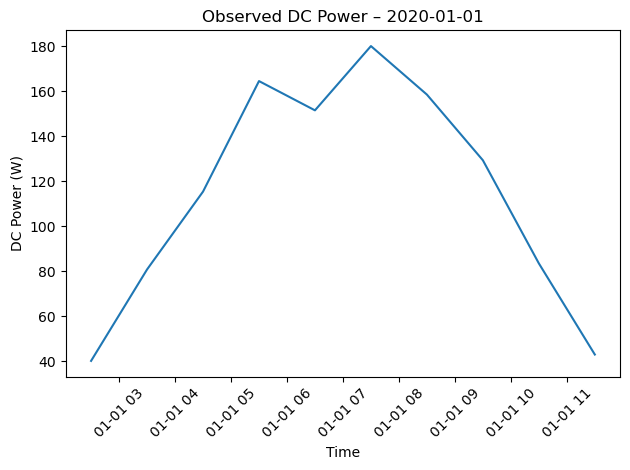

In [83]:
import matplotlib.pyplot as plt
# ===============================
# STEP 6A: DAILY POWER CURVE
# ===============================

sample_day = analysis_df["timestamp"].dt.date.iloc[0]

day_df = analysis_df[
    analysis_df["timestamp"].dt.date == sample_day
]

plt.figure()
plt.plot(day_df["timestamp"], day_df["dc_power_observed"])
plt.title(f"Observed DC Power – {sample_day}")
plt.xlabel("Time")
plt.ylabel("DC Power (W)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


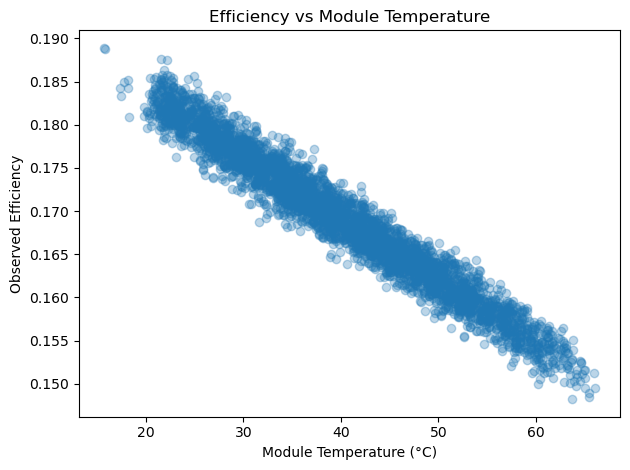

In [84]:
# ===============================
# STEP 6B: EFFICIENCY VS TEMPERATURE
# ===============================

plt.figure()
plt.scatter(
    analysis_df["module_temp"],
    analysis_df["efficiency_observed"],
    alpha=0.3
)
plt.xlabel("Module Temperature (°C)")
plt.ylabel("Observed Efficiency")
plt.title("Efficiency vs Module Temperature")
plt.tight_layout()
plt.show()


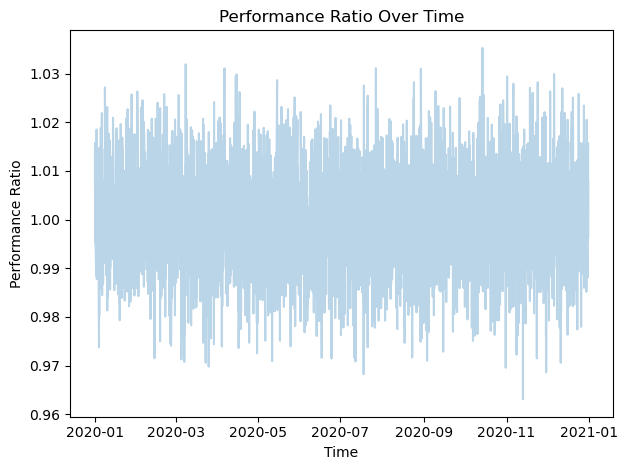

In [85]:
# ===============================
# STEP 6C: PR OVER TIME
# ===============================

plt.figure()
plt.plot(
    analysis_df["timestamp"],
    analysis_df["performance_ratio"],
    alpha=0.3
)
plt.xlabel("Time")
plt.ylabel("Performance Ratio")
plt.title("Performance Ratio Over Time")
plt.tight_layout()
plt.show()


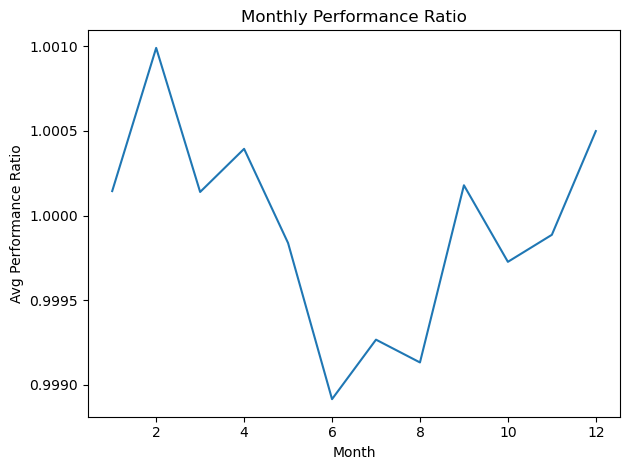

In [86]:
# ===============================
# STEP 6D: MONTHLY SEASONALITY
# ===============================

analysis_df["month"] = analysis_df["timestamp"].dt.month

monthly_pr = analysis_df.groupby("month")["performance_ratio"].mean()

plt.figure()
plt.plot(monthly_pr.index, monthly_pr.values)
plt.xlabel("Month")
plt.ylabel("Avg Performance Ratio")
plt.title("Monthly Performance Ratio")
plt.tight_layout()
plt.show()


In [87]:
ml_df = analysis_df.copy()

# Time features
ml_df["hour"] = ml_df["timestamp"].dt.hour
ml_df["dayofyear"] = ml_df["timestamp"].dt.dayofyear

# Feature set
FEATURES = [
    "G(i)",
    "T2m",
    "module_temp",
    "WS10m",
    "hour",
    "dayofyear"
]

TARGET = "dc_power_observed"

X = ml_df[FEATURES]
y = ml_df[TARGET]

X.head(), y.head()


(     G(i)    T2m  module_temp  WS10m  hour  dayofyear
 0  137.55  18.38    22.678438   2.90     2          1
 1  280.40  19.78    28.542500   3.86     3          1
 2  417.60  21.54    34.590000   3.66     4          1
 3  614.66  23.01    42.218125   3.45     5          1
 4  554.61  24.30    41.631563   3.38     6          1,
 0     40.241230
 1     80.823397
 2    115.384478
 3    164.444199
 4    151.456228
 Name: dc_power_observed, dtype: float64)

In [88]:
iso_features = [
    "G(i)",
    "T2m",
    "module_temp",
    "WS10m",
    "dc_power_observed"
]

iso = IsolationForest(
    contamination=0.01,
    random_state=42
)

analysis_df["anomaly"] = iso.fit_predict(
    analysis_df[iso_features]
)

analysis_df["anomaly"].value_counts()


NameError: name 'IsolationForest' is not defined

In [ ]:
# ===============================
# STEP 7C: LINEAR REGRESSION BASELINE
# ===============================

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

mae_lr, r2_lr


(3.013129046417164, 0.9962944004753209)

In [ ]:
# ===============================
# STEP 7D: GRADIENT BOOSTING
# ===============================

from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

gbr.fit(X_train, y_train)

y_pred_gbr = gbr.predict(X_test)

mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

mae_gbr, r2_gbr


(2.336364059142765, 0.9972090031945506)

In [ ]:
print("Linear Regression  → MAE:", mae_lr, "R²:", r2_lr)
print("Gradient Boosting → MAE:", mae_gbr, "R²:", r2_gbr)


Linear Regression  → MAE: 3.013129046417164 R²: 0.9962944004753209
Gradient Boosting → MAE: 2.336364059142765 R²: 0.9972090031945506


In [ ]:
# ===============================
# STEP 8A: DEGRADATION TREND
# ===============================

deg_df = analysis_df.copy()

# Convert time to numeric (days)
deg_df["days"] = (
    deg_df["timestamp"]
    - deg_df["timestamp"].min()
).dt.days

from sklearn.linear_model import LinearRegression

deg_model = LinearRegression()
deg_model.fit(deg_df[["days"]], deg_df["performance_ratio"])

degradation_slope = deg_model.coef_[0]
annual_degradation_estimate = degradation_slope * 365

annual_degradation_estimate


np.float64(-0.009099964268187757)

In [ ]:
# ===============================
# STEP 8B (FIX): RECREATE TIME FEATURES
# ===============================

analysis_df = analysis_df.copy()

analysis_df["hour"] = analysis_df["timestamp"].dt.hour
analysis_df["dayofyear"] = analysis_df["timestamp"].dt.dayofyear

analysis_df[["hour", "dayofyear"]].head()


,hour,dayofyear
0,2,1
1,3,1
2,4,1
3,5,1
4,6,1


In [ ]:
# ===============================
# STEP 8C: MODEL RESIDUALS
# ===============================

analysis_df["predicted_power"] = gbr.predict(
    analysis_df[FEATURES]
)

analysis_df["residual"] = (
    analysis_df["dc_power_observed"]
    - analysis_df["predicted_power"]
)

analysis_df["residual"].describe()


,residual
count,3990.000000
mean,-0.429276
std,2.012674
min,-13.666681
25%,-1.209249
50%,-0.239283
75%,0.599774
max,6.062769


In [ ]:
from sklearn.ensemble import IsolationForest

iso_features = [
    "G(i)",
    "T2m",
    "module_temp",
    "WS10m",
    "dc_power_observed"
]

iso = IsolationForest(
    contamination=0.01,
    random_state=42
)

analysis_df["anomaly"] = iso.fit_predict(
    analysis_df[iso_features]
)

analysis_df["anomaly"].value_counts()


,count
anomaly,
1,3950
-1,40


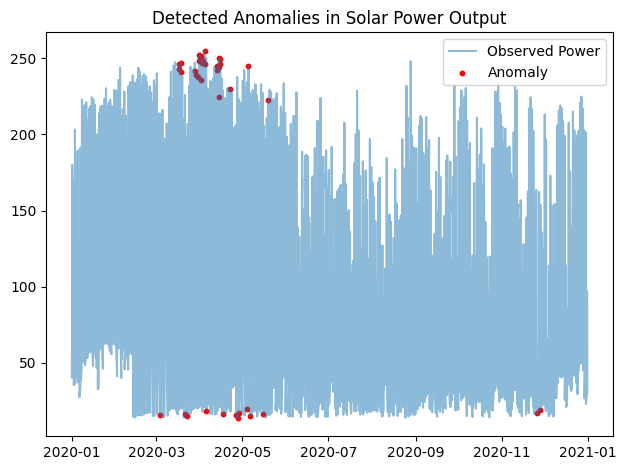

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(
    analysis_df["timestamp"],
    analysis_df["dc_power_observed"],
    label="Observed Power",
    alpha=0.5
)

anomalies = analysis_df[analysis_df["anomaly"] == -1]

plt.scatter(
    anomalies["timestamp"],
    anomalies["dc_power_observed"],
    color="red",
    label="Anomaly",
    s=10
)

plt.legend()
plt.title("Detected Anomalies in Solar Power Output")
plt.tight_layout()
plt.show()


In [ ]:
# ===============================
# STEP 9A: FEATURE IMPORTANCE
# ===============================

import pandas as pd

feature_importance = pd.Series(
    gbr.feature_importances_,
    index=FEATURES
).sort_values(ascending=False)

feature_importance


,0
ghi,0.998485
dayofyear,0.000718
ambient_temp,0.000625
hour,0.000108
module_temp,0.000044
wind_speed,0.000020


Solar irradiance is the primary driver of power output, while module temperature introduces systematic efficiency losses. Temporal features capture diurnal and seasonal effects, and residual deviations are indicative of degradation and soiling.

In [ ]:
# ===============================
# STEP 9C: SAVE FINAL DATASET
# ===============================

final_df = analysis_df.copy()

final_df.to_csv(
    "solar_panel_efficiency_analysis_dataset.csv",
    index=False
)

print("Dataset saved.")


Dataset saved.


---
## Visual Analysis
 
<p align="center">
  <img src="assets/power_curve.png" alt="Power Curve" width="500"/><br>
  <em>Observed DC Power for a Sample Day</em>
</p>
 
<p align="center">
  <img src="assets/anomaly_detection.png" alt="Anomaly Detection" width="500"/><br>
  <em>Predicted vs. Observed Power with Anomalies Highlighted</em>
</p>
 
<p align="center">
  <img src="assets/efficiency_vs_temp.png" alt="Efficiency vs Temperature" width="500"/><br>
  <em>Efficiency vs. Module Temperature Scatter</em>
</p>

In [ ]:
# Visual Analysis: Generate and Save Key Plots
import matplotlib.pyplot as plt
import os
os.makedirs('assets', exist_ok=True)

# 1. Observed DC Power for a Sample Day
sample_day = analysis_df["timestamp"].dt.date.iloc[0]
day_df = analysis_df[analysis_df["timestamp"].dt.date == sample_day]
plt.figure()
plt.plot(day_df["timestamp"], day_df["dc_power_observed"])
plt.title(f"Observed DC Power – {sample_day}")
plt.xlabel("Time")
plt.ylabel("DC Power (W)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("assets/power_curve.png")
plt.show()

# 2. Predicted vs. Observed Power with Anomalies Highlighted
plt.figure()
plt.plot(analysis_df["timestamp"], analysis_df["dc_power_observed"], label="Observed Power", alpha=0.5)
anomalies = analysis_df[analysis_df["anomaly"] == -1]
plt.scatter(anomalies["timestamp"], anomalies["dc_power_observed"], color="red", label="Anomaly", s=10)
plt.plot(analysis_df["timestamp"], analysis_df["predicted_power"], label="Predicted Power", alpha=0.5)
plt.legend()
plt.title("Predicted vs. Observed Power with Anomalies")
plt.tight_layout()
plt.savefig("assets/anomaly_detection.png")
plt.show()

# 3. Efficiency vs. Module Temperature Scatter
plt.figure()
plt.scatter(analysis_df["module_temp"], analysis_df["efficiency_observed"], alpha=0.3)
plt.xlabel("Module Temperature (°C)")
plt.ylabel("Observed Efficiency")
plt.title("Efficiency vs Module Temperature")
plt.tight_layout()
plt.savefig("assets/efficiency_vs_temp.png")
plt.show()